In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


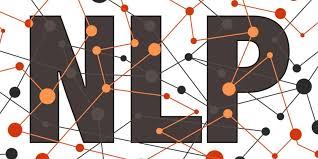

## Importing Necessary Libraries

In [2]:
# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

## Reading Dataset

In [3]:
#training Data
train=pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
print('Training Data Shape',train.shape)
train.head()

Training Data Shape (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Testing data 
test = pd.read_csv('../input/nlp-getting-started/test.csv')
print('Testing data shape: ', test.shape)
test.head()


Testing data shape:  (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Basic EDA

In [5]:
# Counting Number oF Missing values
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

The columns denote the following:

* The text of a tweet
* A keyword from that tweet
* The location the tweet was sent from

In [6]:
#Missing values in test set
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

Lot of **location** values are Missing

## Exploring Target Column

In [7]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

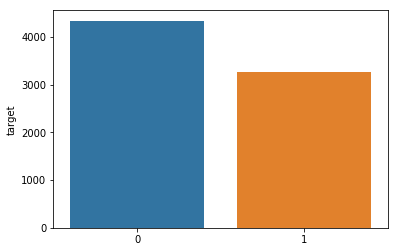

In [8]:
sns.barplot(train['target'].value_counts().index,train['target'].value_counts())

Disaster tweets are Less in Number as compared to Non Disaster Tweets

In [9]:
# A disaster tweet
disaster_tweets = train[train['target']==1]['text']
disaster_tweets.values[1]

'Forest fire near La Ronge Sask. Canada'

In [10]:
#not a disaster tweet
non_disaster_tweets = train[train['target']==0]['text']
non_disaster_tweets.values[1]


'I love fruits'

# Exploring the 'Keyword' Column

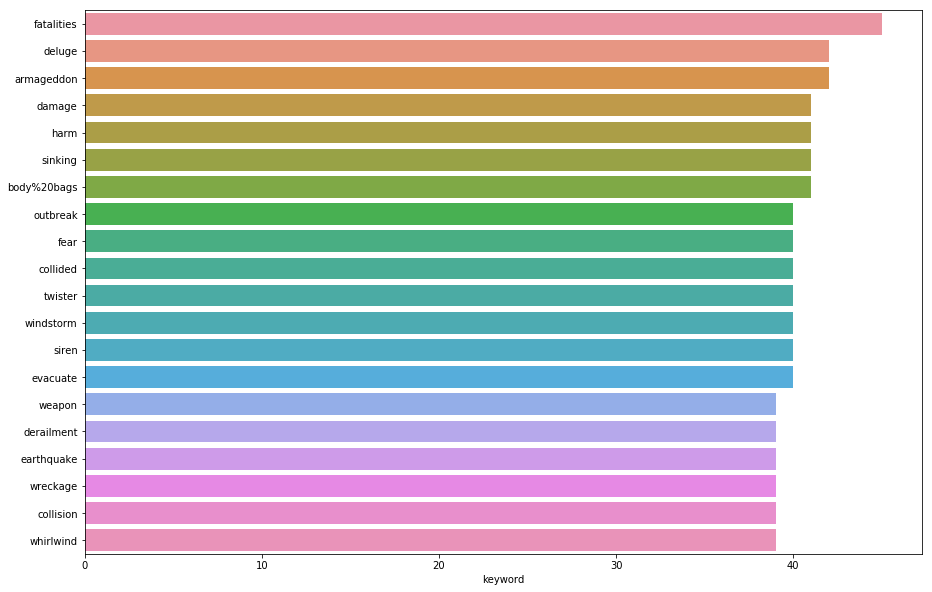

In [11]:
plt.figure(figsize=(15,10))
sns.barplot(y=train['keyword'].value_counts()[:20].index,x=train['keyword'].value_counts()[:20],
            orient='h')


# Text Data Preprocessing

### Data Cleaning
Before we start with any NLP project we need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. Some of the basic text pre-processing techniques includes:

* Make text all **lower case** or uppercase so that the algorithm does not treat the same words in different cases as different
* **Removing Noise** i.e everything that isn’t in a standard number or letter i.e Punctuation, Numerical values, common non-sensical text (/n)
* **Tokenization**: Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.
* **Stopword Removal**: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words

More data cleaning steps after tokenization:

* **Stemming**: Stemming is the process of reducing inflected (or sometimes derived) words to their stem, base or root form — generally a written word form. Example if we were to stem the following words: “Stems”, “Stemming”, “Stemmed”, “and Stemtization”, the result would be a single word “stem”.
* **Lemmatization**: A slight variant of stemming is lemmatization. The major difference between these is, that, stemming can often create non-existent words, whereas lemmas are actual words. So, your root stem, meaning the word you end up with, is not something you can just look up in a dictionary, but you can look up a lemma. Examples of Lemmatization are that “run” is a base form for words like “running” or “ran” or that the word “better” and “good” are in the same lemma so they are considered the same.
* Parts of speech tagging
* Create bi-grams or tri-grams And more...
* However, it is not necessary that you would need to use all these steps. The usage depends on your problem at hand. Sometimes removal of stop words helps while at other times, this might not help.Here is a nice table taken from the blog titled : [All you need to know about Text Preprocessing ](https://kavita-ganesan.com/text-preprocessing-tutorial/#.Xi2BhhczZTY)for Machine Learning & NLP that summarizes how much preprocessing you should be performing on your text data:

In [12]:
# glance at training data
train['text'][:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [13]:
# Applying a first round of text cleaning techniques

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and training datasets
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

# Let's take a look at the updated text
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

## Tokenisation

In [14]:
text = "Are you coming , aren't you"
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')

print("Example Text: ",text)
print("------------------------------------------------------------------------------------------------")
print("Tokenization by whitespace:- ",tokenizer1.tokenize(text))
print("Tokenization by words using Treebank Word Tokenizer:- ",tokenizer2.tokenize(text))
print("Tokenization by punctuation:- ",tokenizer3.tokenize(text))
print("Tokenization by regular expression:- ",tokenizer4.tokenize(text))

Example Text:  Are you coming , aren't you
------------------------------------------------------------------------------------------------
Tokenization by whitespace:-  ['Are', 'you', 'coming', ',', "aren't", 'you']
Tokenization by words using Treebank Word Tokenizer:-  ['Are', 'you', 'coming', ',', 'are', "n't", 'you']
Tokenization by punctuation:-  ['Are', 'you', 'coming', ',', 'aren', "'", 't', 'you']
Tokenization by regular expression:-  ['Are', 'you', 'coming', 'aren', 't', 'you']


In [15]:
# Tokenizing the training and the test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

## Stopwords Removal

In [16]:
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    
    """
    words = [w for w in text if w not in stopwords.words('english')]
    return words


train['text'] = train['text'].apply(lambda x : remove_stopwords(x))
test['text'] = test['text'].apply(lambda x : remove_stopwords(x))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [17]:
# Not used
# # list of list 
# docs=[]
# for i in range(len(train)):
#     docs.append(train['text'][i])
    


## Do we have to Normalize the Tokens here(i.e Stemming or Lemmatiztion ?)


In [18]:
# we are not using this step
# After preprocessing, the text format
# def combine_text(list_of_text):
#     '''Takes a list of text and combines them into one large chunk of text.'''
#     combined_text = ' '.join(list_of_text)
#     return combined_text

# train['text'] = train['text'].apply(lambda x : combine_text(x))
# test['text'] = test['text'].apply(lambda x : combine_text(x))
# train['text']
# train.head()

# Transforming tokens to a vector

After the initial preprocessing phase, we need to transform text into a meaningful vector (or array) of numbers. This can be done by a number of tecniques:

#### Bag of Words
The bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:

1. A vocabulary of known words.
1. A measure of the presence of known words.

Why is it is called a “bag” of words? That is because any information about the order or structure of words in the document is discarded and the model is only concerned with whether the known words occur in the document, not where they occur in the document.

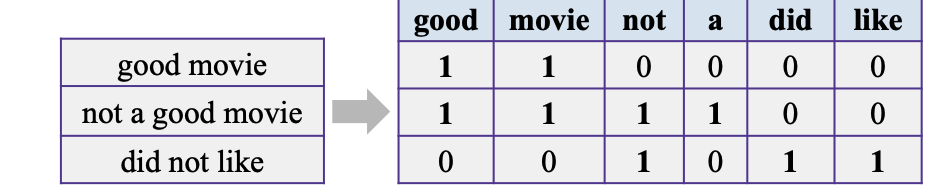

source:[Natural Language Processing course on coursera](https://www.coursera.org/learn/language-processing)

We can do this using scikit-learn's CountVectorizer, where every row will represent a different tweet and every column will represent a different word.

Bag of Words - Countvectorizer Features

**Countvectorizer** converts a collection of text documents to a matrix of token counts. It is important to note here that CountVectorizer comes with a lot of options to automatically do preprocessing, tokenization, and stop word removal.However, i did all the process manually above to just get a better understanding. Let's use a vanilla implementation of the countvectorizer without specifying any parameters.

In [19]:
# Not using here
# # using dfiffrent tokenizer and TfIdf fro SKlearn
# # http://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/
# from sklearn.feature_extraction.text import TfidfVectorizer

# def dummy_fun(doc):
#     return doc

# tfidf = TfidfVectorizer(
#     analyzer='word',
#     tokenizer=dummy_fun,
#     preprocessor=dummy_fun,
#     token_pattern=None)  

# # trainsforming training vector
# train_vectors=tfidf.fit_transform(docs)
# print(len(tfidf.vocabulary_)) # len of vocublary
# print(type(train_vectors))



In [20]:
# After preprocessing, the text format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text
train['text']=train['text'].apply(lambda x: combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))

In [21]:
# NOt used Here
# # transforming test vectors
# test_vectors = tfidf.transform(test["text"])
# print(type(test_vectors))
# print(test_vectors.shape)


# MIN_DF and MAX_DF parameter
**MIN_DF** lets you ignore those terms that appear rarely in a corpus. In other words, if **MIN_df** is 2, it means that a word has to occur at least two documents to be considered useful.

**MAX_DF** on the other hand, ignores terms that have a document frequency strictly higher than the given threshold.These will be words which appear a lot of documents.

This means we can eliminate those words that are either rare or appear too frequently in a corpus.

When mentioned in absolute values i.e 1,2, etc, the value means if the word appears in 1 or 2 documents. However, when given in float, eg 30%, it means it appears in 30% of the documents.

In [22]:
# min_df and max_df 
#https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer
# ngram_range
#https://www.kaggle.com/c/avito-demand-prediction/discussion/58819
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_vectors = tfidf.fit_transform(train['text'])
test_vectors = tfidf.transform(test["text"])

## Building a Text Classification model

Now the data is ready to be fed into a classification model. Let's create a basic claasification model using commonly used classification algorithms and see how our model performs.

In [23]:
clf = LogisticRegression(C=0.90,max_iter=1000,penalty='l2')
# clf = LogisticRegression(C=1.00)
# was  also best when min_df=2,max_df=5,ngram_range=(1,2)
scores = model_selection.cross_val_score(clf, train_vectors, train["target"], cv=7, scoring="f1")
scores

array([0.63709677, 0.52509653, 0.5       , 0.51464968, 0.50874832,
       0.51028807, 0.6962963 ])

In [24]:
clf.fit(train_vectors, train["target"])

LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission["target"] = clf.predict(test_vectors)
sample_submission.to_csv("submission.csv", index=False)

# Sources
1. https://www.kaggle.com/parulpandey/getting-started-with-nlp-a-general-intro/notebook

# Grid Search Method

## Will Implement It soon


In [26]:

# from sklearn.pipeline import Pipeline

# # Create first pipeline for base without reducing features.

# pipe = Pipeline([('classifier' , LogisticRegression())])


# # Create param grid.

# param_grid = [
#     {'classifier' : [LogisticRegression()],
#      'classifier__penalty' : ['l1', 'l2'],
#     'classifier__C' : np.logspace(-4, 4, 20),
#     'classifier__solver' : ['liblinear']},
    
# ]

# # Create grid search object

# clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# # Fit on data

# best_clf = clf.fit(train_vectors, train["target"])


# sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
# sample_submission["target"] = best_clf.predict(test_vectors)
# sample_submission.to_csv("submission.csv", index=False)